In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import (division, print_function, absolute_import)
import numpy as np
from operator import itemgetter

In [3]:
class State:
    def valid_actions(self):
        raise NotImplementeddError()
    def after(move):
        raise NotImplementedError()

In [4]:
class Action:
    pass

In [5]:
class QFunction:
    def __apply__(self, state, action):
        raise NotImplementedError()

In [6]:
class VFunction:
    def __apply__(self, state):
        raise NotImplementedError()

In [7]:
class Policy:
    def distr(self, state):
        raise NotImplementedError()
    def draw(self, state):
        raise NotImplementedError()

In [8]:
class Actor:
    def suggest_action(self, state, max_width, max_depth):
        raise NotImplementedError()

---

In [9]:
class Move(Action):
    def __init__(self, pos):
        self.pos = pos
    def __repr__(self):
        return "(%s, %s)" % (chr(self.pos[0]+64), self.pos[1])

In [10]:
class GomokuState(State):
    def __init__(self, board):
        self.board = board
        
    def valid_actions(self):
        return [Move((x,y)) for x in range(1, board.size+1) 
                for y in range(1, board.size+1) if (x,y) not in self.board.stones]
    
    def after(self, move):
        from copy import deepcopy
        new_state = deepcopy(self)
        new_state.board.set(*move.pos)
        return new_state
    
    def soft_values(self, nh, viewpoint):
        return self.board.lsh.heuristics.soft_values(nh, viewpoint)

In [11]:
class GomokuHeuristicQFunction(QFunction):
    def __init__(self, viewpoint):
        self.viewpoint = viewpoint
        
    def __call__(self, state, action):
        nh = state.board.getn9x9(*action.pos)
        agressive, defensive = state.soft_values(nh=nh, viewpoint=self.viewpoint)
        return agressive + defensive

In [12]:
class GomokuHeuristicVFunction(VFunction):

    def __init__(self, viewpoint):
        self.viewpoint = viewpoint
        
    def __call__(self, state):
        ag = []
        de = []
        for action in state.valid_actions():
            nh = state.board.getn9x9(*action.pos)
            a, d = state.soft_values(nh=nh, viewpoint=self.viewpoint)
            ag.append((action, a))
            de.append((action, d))

        ag = sorted(ag, key=itemgetter(1))[-1]
        de = sorted(de, key=itemgetter(1))[-1]
        
        return ag if ag[1] > de[1] else (de[0], -de[1])

In [13]:
class HeuristicPolicy(Policy):
    def __init__(self, qfunction, viewpoint):
        self.qf = qfunction
        self.viewpoint = viewpoint
    
    def distr(self, state):
        options = [(a, qf(state, a)) for a in state.valid_actions()]
        n = len(options)
        moves = sorted(options, key=itemgetter(1))
        max_val = moves[-1][1]
        best_options = [d for d in moves if d[1] == max_val]
        n_best = len(best_options)
        p = 1.0/n_best
        distr=[(p, m[0]) for m in best_options]
        return distr        
    
    def draw(self, state):
        probs = [0] + [d[0] for d in self.distr(state)]
        boundaries = np.cumsum(probs)/np.sum(probs)
        choices = zip(boundaries, self.distr(state))
        r = np.random.uniform(0,1)
        for i in reversed(choices):
            if r > i[0]:
                return i[1][1]

In [14]:
class PolicyDrivenAdversary(Actor):
    """
    Always takes the top advised action of the policy
    """
    def __init__(self, viewpoint, policy):
        self.viewpoint = viewpoint
        self.policy = policy
        
    def suggest_action(self, state, max_width=1, max_depth=0):
        return self.policy.draw(state)
        
        

In [15]:
class SimpleActor(Actor):
    
    def __init__(self, viewpoint, policy, qf, vf, adversary):
        self.viewpoint = viewpoint
        self.policy = policy
        self.qf = qf
        self.vf = vf
        self.adversary = adversary
        
    def suggest_action(self, state, max_width=1, max_depth=0, verbose=False):
        if max_depth == 0:
            # Special case: No tree search at all
            return self.policy.draw(state)
        else:             
            return self.recursive_suggest(state, max_width, max_depth, verbose)
        
    def recursive_suggest(self, state, max_width, max_depth, verbose):
        import sys
        options = [self.policy.draw(state) for i in range(max_width)]
        maxvalue = -sys.maxint - 1
        for move in options:
            s1 = state.after(move)

            counter = self.adversary.suggest_action(s1, max_width=1, max_depth=0)
            s1.board.set(*counter.pos)

            if verbose:
                tab="  "*(4-max_depth)
                print(tab+"policy    suggests %s" % move)
                print(tab+"adversary suggests %s" % counter)

            value = self.recursive_value(s1, max_width, max_depth, verbose)

            if verbose:
                tab="  "*(4-max_depth)
                print(tab+"value after adversary's reaction: %s" % value[1])

            if value[1] > maxvalue:
                suggestion = (move, value[1])
                maxvalue = value[1]

        return suggestion

    def recursive_value(self, state, max_width, max_depth, verbose):
        if max_depth == 0:
            return self.vf(state)
        else:
            # The value after the best move
            value = self.recursive_suggest(state, max_width, max_depth-1, verbose)
            return value

---

In [16]:
A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S = \
    1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19

In [17]:
from FastGomokuBoard import FastGomokuBoard as Board
board = Board(disp_width=6, size=15)
board.set(H,8).set('G',6).set(7,8).set(6,8).set(8,9).set(8,10).display()

In [18]:
WHITE=1
qf_a = GomokuHeuristicQFunction(viewpoint=WHITE)
policy_a = HeuristicPolicy(qf_a, viewpoint=WHITE)
adversary_model=PolicyDrivenAdversary(WHITE, policy_a)

BLACK=0
qf = GomokuHeuristicQFunction(viewpoint=BLACK)
vf = GomokuHeuristicVFunction(viewpoint=BLACK)
policy = HeuristicPolicy(qf, viewpoint=BLACK)
actor = SimpleActor(BLACK, policy, qf, vf, adversary_model)
state = GomokuState(board)
%time nextAction = actor.suggest_action(state, 2, 3, verbose=False)
nextAction

CPU times: user 28.4 s, sys: 1.15 s, total: 29.5 s
Wall time: 28.7 s


((F, 7), 1320)

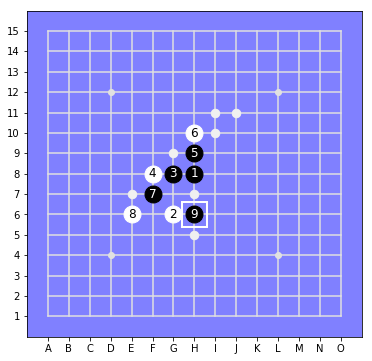

In [21]:
move = actor.suggest_action(state, 2, 3, verbose=False)
board.set(*(move[0].pos)).display()

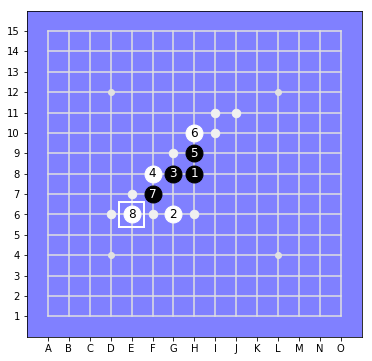

In [20]:
board.set(E,6).display()

In [143]:
board.undo()

<FastGomokuBoard.FastGomokuBoard instance at 0x11fff64d0>

In [174]:
board.save("TreeSearchStudy.csv")